# STRUCTURED PREDICTION

## INDEX

1. [The Datasets](#datasets) <br>
2. [The Structured Perceptron](#sp)<br>
   2.1[CrossNER Music](#cr1)<br>
   2.2[ConLL 2003](#co1)<br>

3. [BI - LSTM](#bilstm)<br>
   3.1[ConLL 2003](#co2)<br>
   3.2[CrossNER](#cr2)<br>

## The Datasets  <a name="datasets"></a>

For the structured prediction task, I aimed to build a NER tagger for music related sentences, to identify songs, artists, albums etc. For this purpose, I decided to work on the CrossNER dataset, available on [github](https://github.com/zliucr/CrossNER), and which indeed was the only dataset of this kind that can currently be found.

As described in the linked page <em>"CrossNER is a fully-labeled collected of named entity recognition (NER) data spanning over five diverse domains (Politics, Natural Science, Music, Literature, and Artificial Intelligence) with specialized entity categories for different domains"</em>.
Given structured prediction was working fairly well and that the dataset provided a new perspective on the main theme of this project and research, I decided to work with its music domain section.

However, due to the limited number of instances, I decided to also download the [CoNLL-2003 Shared Task](https://arxiv.org/pdf/cs/0306050.pdf) dataset, a language-independent named entity recognition dataset with sentences in English and German, which was readily available on the same github page. Although it is a very general dataset not strictly related to the topic of the project, in fact, it could serve as an interesting opportunity to take advantage of the larger volume of instances and therefore more easily experiment with deep learning architectures.

In [1]:
import pandas as pd
from collections import defaultdict, Counter
import json
import re
import numpy as np
import sys
import pickle
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score

np.set_printoptions(precision=2)
numbers = re.compile('[0-9]')
re_special = re.compile("[ö|ü|ä|ß]")

In [ ]:
# CROSSNER MUSIC DATASET
train_music = pd.read_csv("data/CrossNer_train.txt", sep = "\t", header = None, names = ["Word", "Tag"])
dev_music = pd.read_csv("data/CrossNer_dev.txt", sep = "\t", header = None, names = ["Word", "Tag"])
test_music = pd.read_csv("data/CrossNer_test.txt", sep = "\t", header = None, names = ["Word", "Tag"])

In [ ]:
# CONLL 2003 DATASET
train_2003 = pd.read_csv("data/conll2003_train.txt", sep = "\t", header = None, names = ["Word", "Tag"])
dev_2003 = pd.read_csv("data/conll2003_dev.txt", sep = "\t", header = None, names = ["Word", "Tag"])
test_2003 = pd.read_csv("data/conll2003_test.txt", sep = "\t", header = None, names = ["Word", "Tag"])

In [ ]:
# CONLL 2003 COUNTS
count_train_2003 = train_2003.groupby(by = "Tag").count().reset_index().rename(columns = {"Word": "Count"})
count_dev_2003 = dev_2003.groupby(by = "Tag").count().reset_index().rename(columns = {"Word": "Count"})
count_train_2003["Tag"] = count_train_2003["Tag"].apply(lambda x: x[2:] if x != "O" else x)
count_dev_2003["Tag"] = count_dev_2003["Tag"].apply(lambda x: x[2:] if x != "O" else x)

# CROSSNER COUNTS
count_train_music = train_music.groupby(by = "Tag").count().reset_index().rename(columns = {"Word": "Count"})
count_dev_music = dev_music.groupby(by = "Tag").count().reset_index().rename(columns = {"Word": "Count"})
count_train_music["Tag"] = count_train_music["Tag"].apply(lambda x: x[2:] if x != "O" else x)
count_dev_music["Tag"] = count_dev_music["Tag"].apply(lambda x: x[2:] if x != "O" else x)

In [ ]:
print("ConLL 2003 - Available tags:")
train_2003.Tag.unique().tolist()

ConLL 2003 - Available tags:


['B-organisation',
 'O',
 'B-misc',
 'B-person',
 'I-person',
 'B-location',
 'I-organisation',
 'I-misc',
 'I-location']

In [ ]:
print("CrossNER Music - Available tags:")
train_music.Tag.unique().tolist()

CrossNER Music - Available tags:


['O',
 'B-song',
 'I-song',
 'B-band',
 'I-band',
 'B-album',
 'I-album',
 'B-musicgenre',
 'B-musicalartist',
 'B-organisation',
 'I-organisation',
 'I-musicgenre',
 'B-misc',
 'I-misc',
 'B-country',
 'I-country',
 'I-musicalartist',
 'B-award',
 'I-award',
 'B-person',
 'I-person',
 'B-location',
 'I-location',
 'B-musicalinstrument',
 'B-event',
 'I-event',
 'I-musicalinstrument']

To have an idea of how well the algorithm is performing in absolute terms, when looking at the accuracy we should always keep in mind that most of the tokens are tagged "O", i.e. "Other". Specifically, below are reported the training tags distributions and percentages of times the tag is "O", in the training and dev set respectively. 

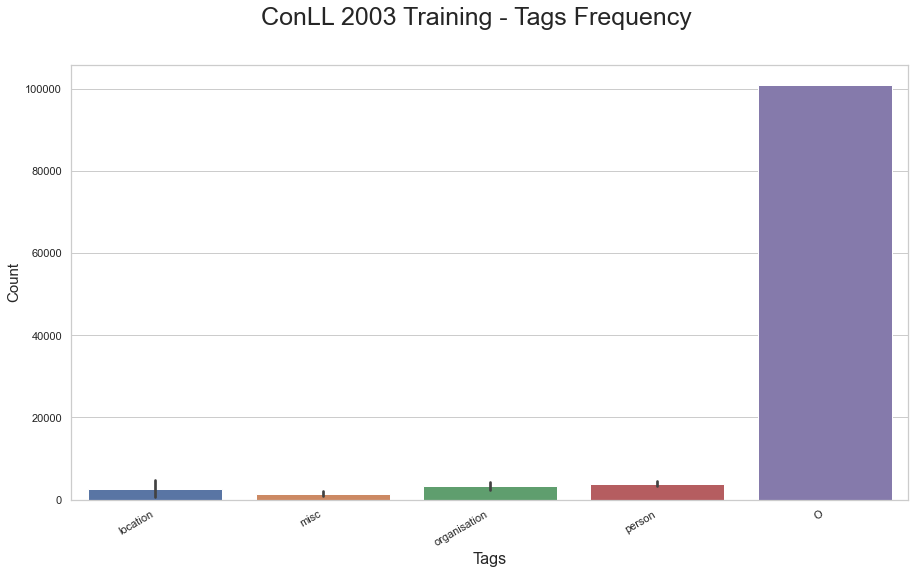

In [ ]:
# TRAINING TAG DISTRO CONLL 2003
sns.set(rc={'figure.figsize':(15,8)})
sns.set_theme(style = "whitegrid")
ax = sns.barplot(x = "Tag",y="Count", data = count_train_2003, dodge=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation= 30, ha="right")
plt.xlabel('Tags', fontsize=16);
plt.ylabel(ylabel = "Count", fontsize = 15);
plt.suptitle("ConLL 2003 Training - Tags Frequency", fontsize=25)
plt.show()

In [ ]:
print(f"Fraction of tags == 'O' in training set: {round(count_train_2003.loc[8, 'Count']/len(train_2003),3)*100}% ")
print()
print(f"Fraction of tags == 'O' in dev set: {round(count_dev_2003.loc[8, 'Count']/len(dev_2003),3)*100}% ")

Fraction of tags == 'O' in training set: 81.69999999999999% 

Fraction of tags == 'O' in dev set: 83.5% 


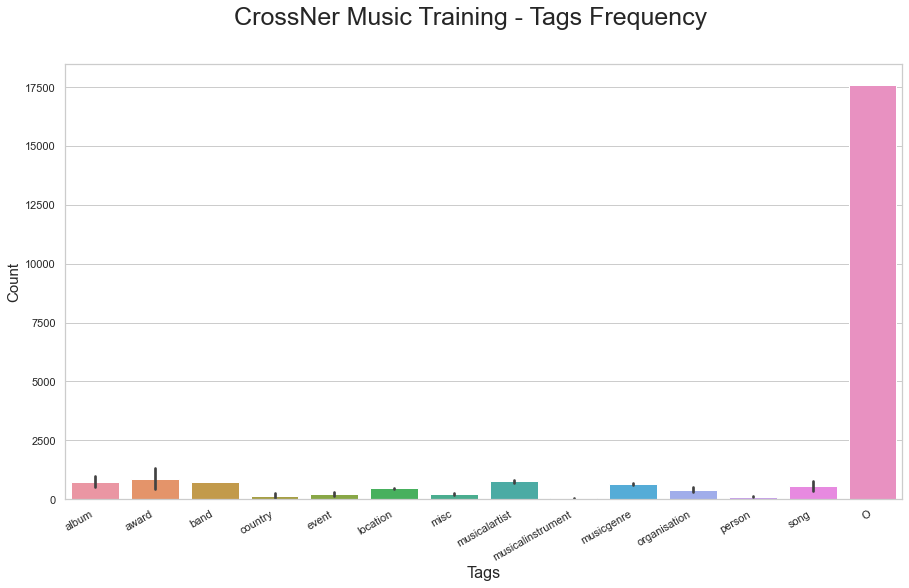

In [ ]:
# TRAINING TAG DISTRO CROSSNER MUSIC
sns.set(rc={'figure.figsize':(15,8)})
sns.set_theme(style = "whitegrid")
ax = sns.barplot(x = "Tag",y="Count", data = count_train_music, dodge=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation= 30, ha="right")
plt.xlabel('Tags', fontsize=16);
plt.ylabel(ylabel = "Count", fontsize = 15);
plt.suptitle("CrossNer Music Training - Tags Frequency", fontsize=25)
plt.show()

In [ ]:
print(f"Fraction of tags == 'O' in training set: {round(count_train_music.loc[26, 'Count']/len(train_music),3)*100}% ")
print()
print(f"Fraction of tags == 'O' in dev set: {round(count_dev_music.loc[26, 'Count']/len(dev_music),3)*100}% ")

Fraction of tags == 'O' in training set: 59.9% 

Fraction of tags == 'O' in dev set: 61.5% 


## THE STRUCTURED PERCEPTRON  <a name="sp"></a>

Firstly, I started experimenteing with the structured perceptron. It was already performing very well, reaching the following resuts with the "greedy" inference method:
- 81% accuracy on the CronnNER Music dev set;
- 97% accuracy on the ConLL 2003 dev set.

The viterbi method, on the other hand, was considerably slower and far less accurate, therefore I decided to put it aside and try to improve on the greedy.

I defined 2 children classes to build upon the structured perceptron seen in class for the POS tagging task. Changes to the parent class strictly regared the get_features function.

In [ ]:
class StructuredPerceptron(object):


    def __init__(self):
        """
        initialize model parameters
        """
        self.tags = set()
        self.feature_weights = defaultdict(lambda: defaultdict(float)) #feature_name -> tags -> weight
        # each feature is mapped to a dictionary telling about the weight for each tag
        
        self.weight_totals = defaultdict(lambda: defaultdict(float)) #feature_name -> tags -> weight
        self.timestamps = defaultdict(lambda: defaultdict(float)) #feature_name -> tags -> weight
        

        self.tag_dict = defaultdict(set) #word -> {tags}

        self.START = "__START__"
        self.END = "__END__"
        
        
    def normalize(self, word):
        """
        Remove numbers and lower word
        """
        return re.sub(numbers, '0', word.strip().lower())

    
    def evaluate(self, data_instances, method='greedy'):
        correct = 0
        total = 0
        for (words, tags) in data_instances: # for each sentence (which is a vector of tuples)
            preds = self.predict(words, method=method)
            matches = sum(map(lambda x: int(x[0]==x[1]), zip(preds, tags)))
            # this creates a vector of 1 when pred[i] == true[i], then sums them all
            correct += matches # at each sentence count and add number of correctly guessed
            total += len(tags)
        return correct/total # NOTE: here we use accuracy
        
    
    def fit(self, file_name, dev_file=None, iterations=10, learning_rate=0.25, inference='greedy', verbose=False):
        """
        read in a CoNLL-format file, extract features to train weight vector
        file with a "word tag" couple per line and every end of sentence we have a space
        NB: this algo works with any label in the training data, could be POS, NER or anything else!
        """        
        # initialize tag dictionary for each word and get tag set
        instances = [(words, tags) for (words, tags) in self.read_conll_file(file_name)]
        for (words, tags) in instances:
            self.tags.update(set(tags))
            # adding to the tags set all various tags encountered in the training corpus (~add for lists)
            # NOTE: first tags is self.tags ! attribute of the class, while second is from the for loop

            for word, tag in zip(words, tags): # updates the word-tag dictionary (for each word has as values all possible tags) )
                self.tag_dict[self.normalize(word)].add(tag)
        
        if dev_file: # IF I have specified a dev file...
            dev_instances = [(words, tags) for (words, tags) in self.read_conll_file(dev_file)]
            
        # REAL fitting procedure    
        # iterate over data
        for iteration in range(1, iterations+1):
            correct = 0
            total = 0
            if verbose:
                print('Iteration {}'.format(iteration+1), file=sys.stderr, flush=True)
                print("*" * 15, file=sys.stderr, flush=True)

            random.shuffle(instances) # instances are shuffled (to prevent some feature is particularly present too many times cosnecutevily)
            for i, (words, tags) in enumerate(instances):
                if i > 0:
                    if i%1000==0:
                        print('%s'%i, file=sys.stderr, flush=True)
                    elif i%20==0:
                        print('.', file=sys.stderr, flush=True, end='')

                # get prediction
                prediction = self.predict(words, method=inference)

                # derive global features (gold = correct and predicted features)
                global_gold_features, global_prediction_features = self.get_global_features(words, prediction, tags)
                                    
                # update weight vector:
                # 1. move closer to true tag
                for tag, fids in global_gold_features.items():
                    for fid, count in fids.items():
                        nr_iters_at_this_weight = iteration - self.timestamps[fid][tag]
                        self.weight_totals[fid][tag] += nr_iters_at_this_weight * self.feature_weights[fid][tag]
                        self.timestamps[fid][tag] = iteration
                        self.feature_weights[fid][tag] += learning_rate * count

                # 2. move further from wrong tag (SAME as ^ but with " - " at the end)
                for tag, fids in global_prediction_features.items():
                    for fid, count in fids.items():
                        nr_iters_at_this_weight = iteration - self.timestamps[fid][tag]
                        self.weight_totals[fid][tag] += nr_iters_at_this_weight * self.feature_weights[fid][tag]
                        self.timestamps[fid][tag] = iteration
                        self.feature_weights[fid][tag] -= learning_rate * count
                        
                # compute training ACCURACY for this iteration
                correct += sum([int(predicted_tag == true_tag) for predicted_tag, true_tag in zip(prediction, tags)])
                total += len(tags)

                # output examples
                if verbose and i%1000==0:
                    print("current word accuracy:{:.2f}".format(correct/total))
                    print(list(zip(words, 
                                   [self.normalize(word) for word in words], 
                                   tags, 
                                   prediction)), file=sys.stderr, flush=True)
            
            print('\t{} features'.format(len(self.feature_weights)), file=sys.stderr, flush=True)
            print('\tTraining accuracy: {:.2f}\n'.format(correct/total), file=sys.stderr, flush=True)
            if dev_file:
                print('\tDevelopment accuracy: {:.2f}\n'.format(self.evaluate(dev_instances, method=inference)), file=sys.stderr, flush=True)
         
        # average the weights instead of just keeping last one, keeping into account that some features appear often, some don't
        for feature, tags in self.feature_weights.items():
            for tag in tags:
                total = self.weight_totals[feature][tag]
                total += (iterations - self.timestamps[feature][tag]) * self.feature_weights[feature][tag]
                averaged = round(total / float(iterations), 3)
                self.feature_weights[feature][tag] = averaged


    def get_features(self, word, previous_tag2, previous_tag, words, i):
        """
        get all features that can be derived from the word and previous tags
        """
        prefix = word[:3]
        suffix = word[-3:]
        
        # a series of STRINGS
        features = {
                    'PREFIX={}'.format(prefix),
                    'SUFFIX={}'.format(suffix),
                    'LEN<=3={}'.format(len(word)<=3),
                    'FIRST_LETTER={}'.format(word[0]),
                    'WORD={}'.format(word),
                    'NORM_WORD={}'.format(words[i]),
                    'PREV_WORD={}'.format(words[i-1]),
                    'PREV_WORD_PREFIX={}'.format(words[i-1][:3]),
                    'PREV_WORD_SUFFIX={}'.format(words[i-1][-3:]),
                    'PREV_WORD+WORD={}+{}'.format(words[i-1], words[i]),
                    'NEXT_WORD={}'.format(words[i+1]),
                    'NEXT_WORD_PREFIX={}'.format(words[i+1][:3]),
                    'NEXT_WORD_SUFFIX={}'.format(words[i+1][-3:]),
                    'WORD+NEXT_WORD={}'.format(word, words[i+1]),
                    'NEXT_2WORDS={}+{}'.format(words[i+1], words[i+2]),
                    'PREV_TAG={}'.format(previous_tag),                 # previous tag
                    'PREV_TAG2={}'.format(previous_tag2),                 # two-previous tag
                    'PREV_TAG_BIGRAM={}+{}'.format(previous_tag2, previous_tag),  # tag bigram
                    'PREV_TAG+WORD={}+{}'.format(previous_tag, word),            # word-tag combination
                    'PREV_TAG+PREFIX={}_{}'.format(previous_tag, prefix),        # prefix and tag
                    'PREV_TAG+SUFFIX={}_{}'.format(previous_tag, suffix),        # suffix and tag
                    'WORD+TAG_BIGRAM={}+{}+{}'.format(word, previous_tag2, previous_tag),
                    'SUFFIX+2TAGS={}+{}+{}'.format(suffix, previous_tag2, previous_tag),
                    'PREFIX+2TAGS={}+{}+{}'.format(prefix, previous_tag2, previous_tag),
            
                     'BIAS'
            }
        return features
    
    
    def get_global_features(self, words, predicted_tags, true_tags):
        '''
        sum up local features
        
        Keep track of global counts?
        ex. {specific_value_of_feature:{Noun : 56,
                                        Verb : 21,
                                        etc...},
            some_other_value:{...}
            }
        '''
        context = [self.START] + [self.normalize(word) for word in words] + [self.END, self.END]

        global_gold_features = defaultdict(lambda: Counter())
        # this is a nested dictionary,with some feature value: {tag: how many times, ...}
        
        global_prediction_features = defaultdict(lambda: Counter())

        prev_predicted_tag = self.START
        prev_predicted_tag2 = self.START
        
        for j, (word, predicted_tag, true_tag) in enumerate(zip(words, predicted_tags, true_tags)):
            # get the predicted features. NB: use j+1, since context is longer than words
            prediction_features = self.get_features(word, prev_predicted_tag2, prev_predicted_tag, context, j+1)

            # update feature correlation with true and predicted tag
            global_prediction_features[predicted_tag].update(prediction_features)
            global_gold_features[true_tag].update(prediction_features)

            prev_predicted_tag2 = prev_predicted_tag
            prev_predicted_tag = predicted_tag

        return global_gold_features, global_prediction_features
            
    
    def get_scores(self, features):
        """
        Gets a bunch of features and use them to build a distribution over the different tags for each word.
        Do this through dictionaries, each index is a tag, value its score, select one with highest score.
        Predict scores for each tag given features.
        ex. {specific_value_of_feature:{Noun : 0.78,
                                        Verb : 0.21,
                                        etc...},
            some_other_value:{...}
            }                             
        """
        scores = defaultdict(float) # each tag will start with prob 0 (score 0)
        
        # add up the scores for each tag, go over all features
        for feature in features:
            if feature not in self.feature_weights: 
                continue # go to next iteration if there is no weight assigned to that tag
            weights = self.feature_weights[feature] 
            for tag, weight in weights.items():
                scores[tag] += weight
            # go through each value for the features retrieved, and add the associated score stored 
            

        # return tag scores
        if not scores:
            # if there are no scores (e.g., first iteration),
            # simply return the first tag with score 1
            scores[list(self.tags)[0]] = 1
        
        return scores


    def predict(self, words, method='greedy'):
        '''
        predict tags using one of two methods
        '''
        if method == 'greedy':
            return self.predict_greedy(words)
        elif method == 'viterbi':
            return self.predict_viterbi(words)


    def predict_viterbi(self, words):
        '''
        predict using Viterbi decoding
        '''
        context = [self.START] + [self.normalize(word) for word in words] + [self.END, self.END]

        N = len(words)
        M = len(self.tags) #number of tags
        tags = sorted(self.tags)

        # create trellis of size M (number of tags) x N (sentence length)
        Q = np.ones((M, N)) * float('-Inf')
        backpointers = np.ones((M, N), dtype=np.int16) * -1 #backpointers

        # initialize probs for tags j at position 1 (first word)
        features = self.get_features(words[0], self.START, self.START, context, 1)
        scores = self.get_scores(features)
        allowed_initial_tags = self.tag_dict[context[1]]

        for j in range(M):
            if not allowed_initial_tags or tags[j] in allowed_initial_tags:
                Q[j,0] = scores[tags[j]]

        # filling the lattice, for every position and every tag find viterbi score Q
        for i in range(1, N):
            allowed_tags = self.tag_dict[context[i+1]]

            # for every previous tag
            for j in range(M):
                best_score = 0.0#float('-Inf')
                prev_tag = tags[j]

                # skip impossible tags
                allowed_previous_tags = self.tag_dict[context[i]]
                if allowed_previous_tags and prev_tag not in allowed_previous_tags:
                    continue

                best_before = Q[j,i-1] # score of previous tag

                # for every possible pre-previous tag
                for k in range(M):
                    if i == 1:
                        prev2_tag = self.START
                    else:
                        prev2_tag = tags[k]
                        # skip impossible tags
                        allowed_previous2_tags = self.tag_dict[context[i-1]]
                        if allowed_previous2_tags and prev2_tag not in allowed_previous2_tags:
                            continue

                    # get features of word i with the two previous tags
                    features = self.get_features(words[i], prev2_tag, prev_tag, context, i+1)
                    scores = self.get_scores(features)

                    # update best score
                    for t in range(M):
                        tag = tags[t]
                        # if word is unknown, use all tags, otherwise allowed ones
                        if not allowed_tags or tag in allowed_tags:
                            tag_score = best_before + scores[tag]

                            if tag_score > best_score:
                                Q[t,i] = tag_score
                                best_score = tag_score
                                backpointers[t,i] = j

        # final best
        best_id = Q[:,-1].argmax()

        # print best tags in reverse order
        predtags = [tags[best_id]]

        for i in range(N-1,0,-1):
            idx = backpointers[best_id, i]
            predtags.append(tags[idx])
            best_id = idx

        #return reversed predtags
        return predtags[::-1]         

    
    def predict_greedy(self, words):
        '''
        greedy prediction
        '''
        context = [self.START] + [self.normalize(word) for word in words] + [self.END, self.END]
                
        prev_predicted_tag = self.START
        prev_predicted_tag2 = self.START

        out = []

        for j, word in enumerate(words):
            # check for UNambiguous words [len(tags for that words) == 1 or None], just look up the tag and use that tag
            # i.e. if a word ONLY has one tag (=unambiguous) we won't have to predict, will just use that tag
            if len(self.tag_dict[context[j+1]]) == 1:
                predicted_tag = list(self.tag_dict[context[j+1]])[0]
                
            else:
                predicted_tag = None

            if not predicted_tag: # if it is == None, given previous line, no previousy predicted tags
                # get the predicted features. NB: use j+1, since context is longer than words
                
                prediction_features = self.get_features(word, prev_predicted_tag2, prev_predicted_tag, context, j+1)
                scores = self.get_scores(prediction_features) # compute a score given those features
                
                # predict the current tag
                predicted_tag = max(scores, key=scores.get) # select tag with highest score ^^

            prev_predicted_tag2 = prev_predicted_tag # update the predicted tags and go to following sentence
            prev_predicted_tag = predicted_tag 

            out.append(predicted_tag)

        return out
    
        
    def read_conll_file(self, file_name):
        """
        read in a file with CoNLL format:
        word1    tag1
        word2    tag2
        ...      ...
        wordN    tagN

        Sentences MUST be separated by newlines!
        """
        current_words = []
        current_tags = []

        with open(file_name, encoding='utf-8') as conll:
            for line in conll:
                line = line.strip()

                if line:
                    word, tag = line.split('\t')
                    current_words.append(word)
                    current_tags.append(tag)

                else:
                    yield (current_words, current_tags)
                    current_words = []
                    current_tags = []

        # if file does not end in newline (it should...), check whether there is an instance in the buffer
        if current_tags != []:
            yield (current_words, current_tags)
        

    def save(self, file_name):
        """
        save model as pickle file
        """
        print("saving model...", end=' ', file=sys.stderr)
        with open(file_name, "wb") as model:
            # pickle cannot save default_dictionaries
            # => make copy and turn into regular dictionaries
            save_feature_weights = defaultdict(lambda: defaultdict(float))
            save_feature_weights.update(self.feature_weights)
            save_tag_dict = defaultdict(set)
            save_tag_dict.update(self.tag_dict)

            save_feature_weights.default_factory = None
            save_tag_dict.default_factory = None
            pickle.dump((save_feature_weights, save_tag_dict, self.tags),
                     model, -1)
        print("done", file=sys.stderr)


    def load(self, file_name):
        """
        load model from pickle file
        """
        print("loading model...", end=' ', file=sys.stderr)
        with open(file_name, 'rb') as model:
            try:
                parameters = pickle.load(model)
            except IOError:
                msg = ("No such model file.")
                raise MissingCorpusError(msg)

            feature_weights, tag_dict, tags = parameters
            self.tags = tags

            # pickle cannot store defaultdicts, so we need a 2-step process
            # 1. initialize
            self.feature_weights = defaultdict(lambda: defaultdict(float))
            self.tag_dict = defaultdict(set)
            
            # 2. update
            self.feature_weights.update(feature_weights)
            self.tag_dict.update(tag_dict)
        print("done", file=sys.stderr)
        return None

In [ ]:
class StructuredPerceptron_CrossNER(StructuredPerceptron):
    def __init__(self):
        super().__init__()
        
    def normalize(self, word):
        """
        Remove numbers and lower word
        """
        return re.sub(numbers, '0', word.strip().lower())
    
    def get_features(self, word, previous_tag2, previous_tag, words, i):
        """
        get all features that can be derived from the word and previous tags
        """
        prefix = word[:3]
        suffix = word[-3:]
        
        # a series of STRINGS
        features = {
                    'PREFIX={}'.format(prefix),
                    'SUFFIX={}'.format(suffix),
                    'LEN<=3={}'.format(len(word)<=3),
                    'FIRST_LETTER={}'.format(word[0]),
                    'WORD={}'.format(word),
                    'NORM_WORD={}'.format(words[i]),
                    'PREV_WORD={}'.format(words[i-1]),
                    'PREV_WORD_PREFIX={}'.format(words[i-1][:3]),
                    'PREV_WORD_SUFFIX={}'.format(words[i-1][-3:]),
                    'PREV_WORD+WORD={}+{}'.format(words[i-1], words[i]),
                    'NEXT_WORD={}'.format(words[i+1]),
                    'NEXT_WORD_PREFIX={}'.format(words[i+1][:3]),
                    'NEXT_WORD_SUFFIX={}'.format(words[i+1][-3:]),
                    'WORD+NEXT_WORD={}'.format(word, words[i+1]),
                    'NEXT_2WORDS={}+{}'.format(words[i+1], words[i+2]),
                    'PREV_TAG={}'.format(previous_tag),                 # previous tag
                    'PREV_TAG2={}'.format(previous_tag2),                 # two-previous tag
                    'PREV_TAG_BIGRAM={}+{}'.format(previous_tag2, previous_tag),  # tag bigram
                    'PREV_TAG+WORD={}+{}'.format(previous_tag, word),            # word-tag combination
                    'PREV_TAG+PREFIX={}_{}'.format(previous_tag, prefix),        # prefix and tag
                    'PREV_TAG+SUFFIX={}_{}'.format(previous_tag, suffix),        # suffix and tag
                    'WORD+TAG_BIGRAM={}+{}+{}'.format(word, previous_tag2, previous_tag),
                    'SUFFIX+2TAGS={}+{}+{}'.format(suffix, previous_tag2, previous_tag),
                    'PREFIX+2TAGS={}+{}+{}'.format(prefix, previous_tag2, previous_tag),
            
                     # ADDED FEATURES
                     'PREVIOUS_TAG_IOB={}'.format(previous_tag[0]), # check previous tag's IOB
                     'CAP={}'.format(word.isupper()), # check if upper
                     'PREV_TAG+CAP={}+{}'.format(previous_tag, word[0].isupper()), # check previous tag + if upper
            
                     'BIAS'
            }
        return features

In [ ]:
class StructuredPerceptron_ConLL(StructuredPerceptron):
    def __init__(self):
        super().__init__()
        
    def normalize(self, word):
        """
        Remove numbers and lower word
        """
        return re.sub(numbers, '0', word.strip().lower())
    
    def get_features(self, word, previous_tag2, previous_tag, words, i):
        """
        get all features that can be derived from the word and previous tags
        """
        prefix = word[:3]
        suffix = word[-3:]
        
        # a series of STRINGS
        features = {
                    'PREFIX={}'.format(prefix),
                    'SUFFIX={}'.format(suffix),
                    'LEN<=3={}'.format(len(word)<=3),
                    'FIRST_LETTER={}'.format(word[0]),
                    'WORD={}'.format(word),
                    'NORM_WORD={}'.format(words[i]),
                    'PREV_WORD={}'.format(words[i-1]),
                    'PREV_WORD_PREFIX={}'.format(words[i-1][:3]),
                    'PREV_WORD_SUFFIX={}'.format(words[i-1][-3:]),
                    'PREV_WORD+WORD={}+{}'.format(words[i-1], words[i]),
                    'NEXT_WORD={}'.format(words[i+1]),
                    'NEXT_WORD_PREFIX={}'.format(words[i+1][:3]),
                    'NEXT_WORD_SUFFIX={}'.format(words[i+1][-3:]),
                    'WORD+NEXT_WORD={}'.format(word, words[i+1]),
                    'NEXT_2WORDS={}+{}'.format(words[i+1], words[i+2]),
                    'PREV_TAG={}'.format(previous_tag),                 # previous tag
                    'PREV_TAG2={}'.format(previous_tag2),                 # two-previous tag
                    'PREV_TAG_BIGRAM={}+{}'.format(previous_tag2, previous_tag),  # tag bigram
                    'PREV_TAG+WORD={}+{}'.format(previous_tag, word),            # word-tag combination
                    'PREV_TAG+PREFIX={}_{}'.format(previous_tag, prefix),        # prefix and tag
                    'PREV_TAG+SUFFIX={}_{}'.format(previous_tag, suffix),        # suffix and tag
                    'WORD+TAG_BIGRAM={}+{}+{}'.format(word, previous_tag2, previous_tag),
                    'SUFFIX+2TAGS={}+{}+{}'.format(suffix, previous_tag2, previous_tag),
                    'PREFIX+2TAGS={}+{}+{}'.format(prefix, previous_tag2, previous_tag),
            
                     # ADDED FEATURES
                     'PREVIOUS_TAG_IOB={}'.format(previous_tag[0]), # check previous tag's IOB
                     'CAP={}'.format(word.isupper()), # check if upper
                     'PREV_TAG+CAP={}+{}'.format(previous_tag, word[0].isupper()), # check previous tag + if upper
                     'SPECIAL={}'.format(bool(re.search(re_special, word.lower()))), # check if special characters in word
                     'LONG={}'.format(len(word)> 10), # check if word length is > 10 characters
            
                     'BIAS'
            }
        return features

## CrossNER  <a name="cr1"></a>

The structured perceptron with the original set of features on average reaches unstable peaks of 82% accuracy after around 6 iterations. Adding three simple extra features it reaches that same value someway quicker and remains slightly more stable around it for a few iterations. These results suggest that the optimal structured perceptron should make use of such features and run for around 5 iterations.
Added features were:
   - PREV_TAG_IOB: returning whether the previous tag had a B (beginning), I (inside) or O (other) prefix;
   - CAP: returning whether the current word is capitalized;
   - PREV_TAG+CAP: returning bigram of previous tag and whther current word is upper.

In [ ]:
# OG - GREEDY CROSSNER MUSIC - ORIGINAL
sp_cn_og = StructuredPerceptron()
inference_method = 'greedy'
%time sp_cn_og.fit('CrossNer_train.txt', dev_file='CrossNer_dev.txt', iterations=10, inference=inference_method)
#sp_cn_og.save('model_greedy_music_og.pickle')

...................................	132092 features
	Training accuracy: 0.81

	Development accuracy: 0.79

...................................	147093 features
	Training accuracy: 0.92

	Development accuracy: 0.78

...................................	154326 features
	Training accuracy: 0.94

	Development accuracy: 0.81

...................................	157884 features
	Training accuracy: 0.96

	Development accuracy: 0.79

...................................	160035 features
	Training accuracy: 0.97

	Development accuracy: 0.80

...................................	161546 features
	Training accuracy: 0.97

	Development accuracy: 0.82

...................................	162548 features
	Training accuracy: 0.98

	Development accuracy: 0.80

...................................	163306 features
	Training accuracy: 0.98

	Development accuracy: 0.81

...................................	163936 features
	Training accuracy: 0.99

	Development accuracy: 0.82

...................................	1

CPU times: total: 2min 13s
Wall time: 2min 13s


saving model... done


In [ ]:
# OG - VITERBI CROSSNER MUSIC
sp_cn_og2 = StructuredPerceptron()
inference_method = 'viterbi'
%time sp_cn_og2.fit('CrossNer_train.txt', dev_file='CrossNer_dev.txt', iterations=5, inference=inference_method)

#sp_cn_og2.save('model_viterbi_music.pickle')

...................................	110295 features
	Training accuracy: 0.58

	Development accuracy: 0.59

...................................	110748 features
	Training accuracy: 0.58

	Development accuracy: 0.59

...................................	110868 features
	Training accuracy: 0.58

	Development accuracy: 0.59

...................................	110880 features
	Training accuracy: 0.58

	Development accuracy: 0.59

...................................	110890 features
	Training accuracy: 0.58

	Development accuracy: 0.59



CPU times: total: 15min 56s
Wall time: 15min 57s


saving model... done


In [ ]:
# GREEDY CROSSNER MUSIC - UPDATED
sp_cn = StructuredPerceptron_CrossNER()
inference_method = 'greedy'
%time sp_cn.fit('CrossNer_train.txt', dev_file='CrossNer_dev.txt', iterations=10, inference=inference_method)
#sp_cn.save('model_greedy_music.pickle')

...................................	132193 features
	Training accuracy: 0.81

	Development accuracy: 0.77

...................................	148062 features
	Training accuracy: 0.90

	Development accuracy: 0.80

...................................	156463 features
	Training accuracy: 0.93

	Development accuracy: 0.82

...................................	161042 features
	Training accuracy: 0.95

	Development accuracy: 0.82

...................................	163154 features
	Training accuracy: 0.97

	Development accuracy: 0.82

...................................	164953 features
	Training accuracy: 0.97

	Development accuracy: 0.81

...................................	166218 features
	Training accuracy: 0.98

	Development accuracy: 0.82

...................................	166947 features
	Training accuracy: 0.98

	Development accuracy: 0.80

...................................	167491 features
	Training accuracy: 0.99

	Development accuracy: 0.81

...................................	1

CPU times: total: 2min 30s
Wall time: 2min 32s


saving model... done


In [ ]:
# GREEDY CROSSNER MUSIC - UPDATED
sp_cn = StructuredPerceptron_CrossNER()
inference_method = 'greedy'
%time sp_cn.fit('CrossNer_train.txt', dev_file='CrossNer_dev.txt', iterations=5, inference=inference_method)
#sp_cn.save('model_greedy_music_update.pickle')

...................................	132225 features
	Training accuracy: 0.81

	Development accuracy: 0.77

...................................	148270 features
	Training accuracy: 0.90

	Development accuracy: 0.60

...................................	156270 features
	Training accuracy: 0.93

	Development accuracy: 0.82

...................................	160429 features
	Training accuracy: 0.95

	Development accuracy: 0.81

...................................	163103 features
	Training accuracy: 0.96

	Development accuracy: 0.82



CPU times: total: 22.8 s
Wall time: 22.9 s


saving model... done


## ConLL 2003  <a name="co1"></a>

The performance of the original structured perceptron was already extremely good, but I tried to add a few simple features to the orinal set, specifically PREV_TAG_IOB, CAP, PREV_TAG+CAP, as in the CrossNER task, plus 2 features specifically to account for the fact that the ConLL dataset also includes German sentences:

   - LONG: returning if word length is > 10 characters; in fact, the average English word ranges from 5-9 characters of length, whereas German words are considerably longer, ranging from 6-11 , depending on the source ([1](https://arxiv.org/ftp/arxiv/papers/1207/1207.2334.pdf), [2](http://www.ravi.io/language-word-lengths), [3](http://www.puchu.net/doc/Average_Word_Length));
   - SPECIAL: returning whether any special character is present in the current word (i.e. umlauted or eszett).
   
However, these features, although somewhat rational, didn't really affect the performance, so I preferred to discard them and consider the original model with fewer features as the optimal.

In [ ]:
# GREEDY CONLL 2003 - ORIGINAL FEATURES
sp_2003_og = StructuredPerceptron()
inference_method = 'greedy'
%time sp_2003_og.fit('conll2003_train.txt', dev_file='conll2003_dev.txt', iterations=5, inference=inference_method)
#sp_2003_og.save('model_greedy_2003_og.pickle')

.................................................1000
.................................................2000
.................................................3000
.................................................4000
.................................................5000
.................................................6000
.................................................7000
.................................................8000
.................................................9000
.................................................10000
.................................................11000
.................................................12000
.................................................13000
.................................................14000
.................................................	448522 features
	Training accuracy: 0.97

	Development accuracy: 0.96

.................................................1000
.................................................2000
..........

CPU times: total: 3min 5s
Wall time: 3min 6s


saving model... done


In [ ]:
# GREEDY CONLL 2003 - UPDATED
sp_2003 = StructuredPerceptron_ConLL()
inference_method = 'greedy'
%time sp_2003.fit('conll2003_train.txt', dev_file='conll2003_dev.txt', iterations=5, inference=inference_method)
#sp_2003.save('model_greedy_2003.pickle')

.................................................1000
.................................................2000
.................................................3000
.................................................4000
.................................................5000
.................................................6000
.................................................7000
.................................................8000
.................................................9000
.................................................10000
.................................................11000
.................................................12000
.................................................13000
.................................................14000
.................................................	449520 features
	Training accuracy: 0.97

	Development accuracy: 0.95

.................................................1000
.................................................2000
..........

CPU times: total: 2min 43s
Wall time: 2min 45s


saving model... done


## TESTING AND TEST SET

In [3]:
def evaluate_test(model, test, inference = "greedy"):
    test_instances = [(words, tags) for (words, tags) in read_conll_file(test)]
    accuracy = model.evaluate(test_instances, method = inference)
    print("Testing accuracy:", accuracy)
    return accuracy

def read_conll_file(file_name):

    current_words = []
    current_tags = []

    with open(file_name, encoding='utf-8') as conll:
        for line in conll:
            line = line.strip()

            if line:
                word, tag = line.split('\t')
                current_words.append(word)
                current_tags.append(tag)

            else:
                yield (current_words, current_tags)
                current_words = []
                current_tags = []

    if current_tags != []:
        yield (current_words, current_tags)
        
def bootstrap_sample(system1, system2, gold, samples=1000, score=f1_score, average='macro'):

    N = len(gold) # number of instances
    
    # make sure the two systems have the same number of samples
    assert len(system1) == N and len(system2) == N, 'samples have different lengths'

    # compute performance score on entire sample
    if score == accuracy_score:
        base_score1 = score(gold, system1)
        base_score2 = score(gold, system2)
        print("Base difference: {} vs. {}".format(base_score1, base_score2))
    else:    
        base_score1 = score(gold, system1, average=average)
        base_score2 = score(gold, system2, average=average)
        print("Base difference: {} vs. {}".format(base_score1, base_score2))

    # switch systems if system2 is better
    if base_score2 > base_score1:
        system1, system2 = system2, system1
        base_score1, base_score2 = base_score2, base_score1
    
    # compute the difference
    basedelta = base_score1 - base_score2
    assert basedelta > 0, 'Wrong system first, system1 needs to be better!'

    system1 = np.array(system1)
    system2 = np.array(system2)
    gold = np.array(gold)

    p = 0
    deltas = []
    for i in range(samples):
        # select a subsample, with replacement
        sample = np.random.choice(N, size=N, replace=True)

        # collect data corresponding to subsample
        sample1 = system1[sample]
        sample2 = system2[sample]
        gold_sample = gold[sample]

        # compute scores on subsample
        if score == accuracy_score:
            
            sample_score1 = score(gold_sample, sample1)
            sample_score2 = score(gold_sample, sample2)
            sample_delta = sample_score1 - sample_score2
        else:
            sample_score1 = score(gold_sample, sample1, average=average)
            sample_score2 = score(gold_sample, sample2, average=average)
            sample_delta = sample_score1 - sample_score2


        # check whether the observed sample difference is at least 
        # twice as large as the base difference
        if sample_delta > 2*basedelta:
            p += 1
        deltas.append(sample_delta)
                
    return p/samples, deltas


### CrossNER

The model is far from perfect, although it can understand when a made up band, prize or album is introduced. There still are some weird guesses.

In [ ]:
sp_tests_crossner = StructuredPerceptron_CrossNER()
sp_tests_crossner.load("model_greedy_music_update.pickle")

loading model... done


In [ ]:
print(sp_tests_crossner.predict("This track by Ur Favourite Band is awesome, it should win an Ammy".split(), method='greedy'))

['O', 'O', 'O', 'B-musicalartist', 'I-band', 'I-band', 'O', 'O', 'O', 'I-song', 'O', 'O', 'B-award']


In [ ]:
print(sp_tests_crossner.predict("Check out this tape, it's is called NLP Tune".split(), method='greedy'))

['B-album', 'O', 'O', 'O', 'O', 'O', 'O', 'B-album', 'I-album']


In [ ]:
print(sp_tests_crossner.predict("Will you come to The Strokes gig? They will play at Magazzini Generali".split(), method='greedy'))

['O', 'O', 'O', 'O', 'B-band', 'I-band', 'O', 'B-band', 'O', 'O', 'O', 'B-location', 'I-location']


Evaluate testing accuracy.

In [ ]:
evaluate_test(sp_tests_crossner, "CrossNer_test.txt")

Testing accuracy: 0.8429265796878997


0.8429265796878997

### ConLL 2003

The model was perfoming very well on the ConLL 2003 dataset, although it seems heavily relying on capital letters, despite the fact I ended up not including the feature in the final model.

In [ ]:
sp_tests_conll = StructuredPerceptron()
sp_tests_conll.load("model_greedy_2003_og.pickle")

loading model... done


In [ ]:
print(sp_tests_conll.predict("My friend Maria is working at ONU currently".split(), method='greedy'))

['O', 'O', 'B-person', 'O', 'O', 'O', 'B-location', 'O']


In [ ]:
print(sp_tests_conll.predict("My friend maria is working at ONU currently".split(), method='greedy'))

['O', 'O', 'O', 'O', 'O', 'O', 'B-location', 'O']


In [ ]:
print(sp_tests_conll.predict("When I met Matteo, he was studying DSBA at Bocconi University".split(), method='greedy'))

['O', 'O', 'O', 'B-person', 'O', 'O', 'O', 'O', 'O', 'B-location', 'I-organisation']


In [ ]:
print(sp_tests_conll.predict("Ich habe Google Translate verwendet, um diesen Satz zu schreiben".split(), method='greedy'))

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-person', 'O', 'O']


Evaluate testing accuracy.

In [ ]:
evaluate_test(sp_tests_conll, "conll2003_test.txt")

Testing accuracy: 0.953326434700125


0.953326434700125

# BI-LSTM  <a name="bilstm"></a>

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers import GlobalMaxPooling1D, Dropout
from keras.layers.core import Dense, Activation
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding
from keras.layers import Bidirectional, LSTM
from keras.layers import Dropout, Dense, Activation
import numpy as np
from keras.layers import Bidirectional

To beat the structured perceptron baseline, I started experimenting eith the Bidirectional Long Short Term Memory model, given that according to the literature it seemed to be one of the better alternatives to work on the ConLL 2003 dataset, and I wanted to see how it would perform on the CrossNER data as well.

First, some preprocessing steps were needed. For simplicity, in the cell below it is possible to specify the dataset of interest, so that one can then run all the preprocessing cells, and finally the 2 models are distinguished.

In [26]:
dataset_ = "crossner" #alternatively "crossner"

if dataset_ == "conll":
    train_BI_LSTM = "conll2003_train.txt"
    dev_BI_LSTM = "conll2003_dev.txt"
    test_BI_LSTM = "conll2003_test.txt"
    
elif dataset_ == "crossner":
    train_BI_LSTM = "CrossNer_train.txt"
    dev_BI_LSTM = "CrossNer_dev.txt"
    test_BI_LSTM = "CrossNer_test.txt"

Firstly we need to generate sets of all words and tags, map each of them to an integer and store the mapping from one to another through dictionaries.

In [27]:
def convert2ints(instances):
    result = []
    for (words, tags) in instances:
        # replace words with int, 1 for unknown words
        word_ints = [word2int.get(word, 1) for word in words]
        # replace tags with int
        tag_ints = [tag2int[tag] for tag in tags]
        result.append((word_ints, tag_ints))
    return result  

In [28]:
wordset, tagset = set(), set()
train_instances = [(words, tags) for (words, tags) in read_conll_file(train_BI_LSTM)]
for (words, tags) in train_instances:
    tagset.update(set(tags))
    wordset.update(set(words))

# map words and tags into ints
PAD = '-PAD-'
UNK = '-UNK-'
word2int = {word: i + 2 for i, word in enumerate(sorted(wordset))}
word2int[PAD] = 0  # special token for padding
word2int[UNK] = 1  # special token for unknown words
 
tag2int = {tag: i + 1 for i, tag in enumerate(sorted(tagset))}
tag2int[PAD] = 0
# to translate it back
int2tag = {i:tag for tag, i in tag2int.items()} 

In [29]:
# get some dev and test data
dev_instances = [(words, tags) for (words, tags) in read_conll_file(dev_BI_LSTM)]
test_instances = [(words, tags) for (words, tags) in read_conll_file(test_BI_LSTM)]

# apply integer mapping
train_instances_int = convert2ints(train_instances)
dev_instances_int = convert2ints(dev_instances)
test_instances_int = convert2ints(test_instances)

# separate the words from the tags
train_sentences, train_tags = zip(*train_instances_int) 
dev_sentences, dev_tags = zip(*dev_instances_int) 
test_sentences, test_tags = zip(*test_instances_int) 

print(train_instances[0][0])
print(train_sentences[0])
print(train_instances[0][1])
print(train_tags[0])

['It', 'is', 'based', 'on', 'the', 'classic', 'song', 'The', 'Guns', 'of', 'Brixton', 'on', 'The', 'Clash', "'", 's', 'London', 'Calling', 'and', 'has', 'proven', 'to', 'be', 'a', 'success', 'on', 'the', 'modern', 'rock', 'charts', '.']
[2031, 5233, 4385, 5488, 6057, 4535, 5935, 3790, 1753, 5477, 703, 5488, 3790, 936, 6, 5812, 2331, 777, 4305, 5093, 5656, 6081, 4395, 4223, 6001, 5488, 6057, 5393, 5797, 4517, 32]
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-song', 'I-song', 'I-song', 'I-song', 'O', 'B-band', 'I-band', 'O', 'O', 'B-album', 'I-album', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-musicgenre', 'O', 'O']
[27, 27, 27, 27, 27, 27, 27, 13, 26, 26, 26, 27, 3, 16, 27, 27, 1, 14, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 10, 27, 27]


To bring every sentence to the same length we find the maximum length over the training data, add 5 and pad up to the found maximum length.

In [30]:
# get longest training sentence and add 5
MAX_LENGTH = len(max(train_sentences, key=len)) + 5
print(MAX_LENGTH)

87


In [31]:
# add special padding at the end of every instance, up to MAX_LENGTH
train_sentences = pad_sequences(train_sentences, maxlen=MAX_LENGTH, padding='post')
dev_sentences = pad_sequences(dev_sentences, maxlen=MAX_LENGTH, padding='post')
test_sentences = pad_sequences(test_sentences, maxlen=MAX_LENGTH, padding='post')

train_tags = pad_sequences(train_tags, maxlen=MAX_LENGTH, padding='post')
dev_tags = pad_sequences(dev_tags, maxlen=MAX_LENGTH, padding='post')
test_tags = pad_sequences(test_tags, maxlen=MAX_LENGTH, padding='post')
 
print(train_sentences[0])
print(train_tags[0])

[2031 5233 4385 5488 6057 4535 5935 3790 1753 5477  703 5488 3790  936
    6 5812 2331  777 4305 5093 5656 6081 4395 4223 6001 5488 6057 5393
 5797 4517   32    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]
[27 27 27 27 27 27 27 13 26 26 26 27  3 16 27 27  1 14 27 27 27 27 27 27
 27 27 27 27 10 27 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


We then generate 1-hot distributions for the tags.

In [32]:
train_tags_1hot = to_categorical(train_tags, len(tag2int))
dev_tags_1hot = to_categorical(dev_tags, len(tag2int))
test_tags_1hot = to_categorical(test_tags, len(tag2int))

# originally 50 tag IDs
print(train_tags[0])
# now 50 rows with 13 columns
print(train_tags_1hot[0].shape)
# the 1-hot encoding of tag ID 7
print(train_tags_1hot[0])

[27 27 27 27 27 27 27 13 26 26 26 27  3 16 27 27  1 14 27 27 27 27 27 27
 27 27 27 27 10 27 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
(87, 28)
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


Finally, we define the model and run it.

## ConLL 2003  <a name="co2"></a>

It looked like decreasing the batch size was having a positive effect on the dev accuracy, and observing the development accuracy's trajectory it also appeared the best performance was reached with just 2 iterations.

In [16]:
if dataset_ == "crossner":
  print("Should preprocess the ConLL dataset to run this model! Specify dataset_ = 'conll' in the appropriate cell!")
  raise Exception("Should preprocess the ConLL dataset to run this model!")

np.random.seed(42)

inputs = Input((MAX_LENGTH, ), 
               name='word_IDs')
embeddings = Embedding(input_dim=len(word2int), 
                       output_dim=128, 
                       mask_zero=True, 
                       name='embeddings')(inputs)
#wrap the LSTM in a Bidirectional wrapper
bilstm = Bidirectional(LSTM(units=256, 
                            return_sequences=True), 
                       name="Bi-LSTM")(embeddings)
dropout = Dropout(0.3, name='dropout')(bilstm)
bilstm_out = Dense(len(tag2int), name='output')(dropout)
output = Activation('softmax', name='softmax')(bilstm_out)

model_bilstm = Model(inputs=[inputs], outputs=[output])
model_bilstm.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_IDs (InputLayer)       [(None, 118)]             0         
                                                                 
 embeddings (Embedding)      (None, 118, 256)          6048000   
                                                                 
 Bi-LSTM (Bidirectional)     (None, 118, 256)          394240    
                                                                 
 dropout (Dropout)           (None, 118, 256)          0         
                                                                 
 output (Dense)              (None, 118, 10)           2570      
                                                                 
 softmax (Activation)        (None, 118, 10)           0         
                                                                 
Total params: 6,444,810
Trainable params: 6,444,810
Non-tra

Epoch 1/10
1874/1874 [==============================] - 295s 152ms/step - loss: 0.0343 - accuracy: 0.9202 - val_loss: 0.0179 - val_accuracy: 0.9586
Epoch 2/10
1874/1874 [==============================] - 284s 151ms/step - loss: 0.0059 - accuracy: 0.9857 - val_loss: 0.0157 - val_accuracy: 0.9642
Epoch 3/10
1874/1874 [==============================] - 286s 153ms/step - loss: 0.0023 - accuracy: 0.9944 - val_loss: 0.0156 - val_accuracy: 0.9668
Epoch 4/10
1874/1874 [==============================] - 287s 153ms/step - loss: 0.0013 - accuracy: 0.9966 - val_loss: 0.0174 - val_accuracy: 0.9662
Epoch 5/10
1874/1874 [==============================] - 288s 154ms/step - loss: 7.4674e-04 - accuracy: 0.9979 - val_loss: 0.0194 - val_accuracy: 0.9643
Epoch 6/10
1874/1874 [==============================] - 283s 151ms/step - loss: 5.6707e-04 - accuracy: 0.9986 - val_loss: 0.0193 - val_accuracy: 0.9655
Epoch 7/10
1874/1874 [==============================] - 276s 147ms/step - loss: 3.4984e-04 - accuracy: 0

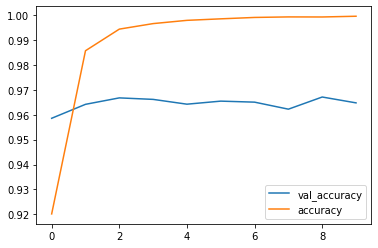

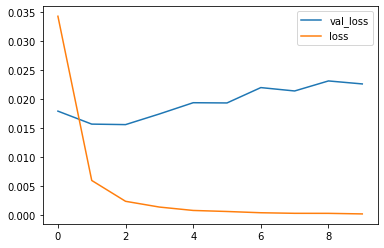

In [12]:
# first test
batch_size = 8
epochs = 10

model_bilstm.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

history_bilstm = model_bilstm.fit(train_sentences, train_tags_1hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(dev_sentences, dev_tags_1hot))

df = pd.DataFrame(history_bilstm.history)
df[['val_accuracy', 'accuracy']].plot.line();
df[['val_loss', 'loss']].plot.line();

Epoch 1/2
1874/1874 [==============================] - 307s 160ms/step - loss: 8.5505e-04 - accuracy: 0.9978 - val_loss: 0.0224 - val_accuracy: 0.9613
Epoch 2/2
1874/1874 [==============================] - 303s 162ms/step - loss: 6.2110e-04 - accuracy: 0.9984 - val_loss: 0.0217 - val_accuracy: 0.9649


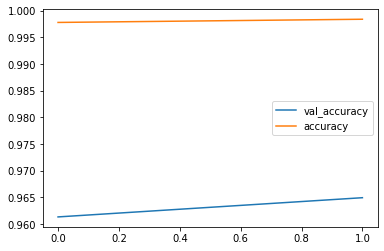

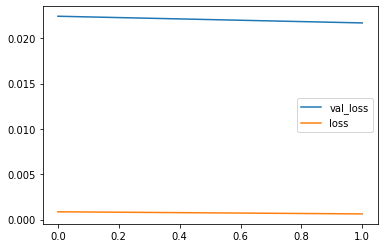

In [19]:
batch_size = 8
epochs = 2

model_bilstm.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

history_bilstm = model_bilstm.fit(train_sentences, train_tags_1hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(dev_sentences, dev_tags_1hot))

df = pd.DataFrame(history_bilstm.history)
df[['val_accuracy', 'accuracy']].plot.line();
df[['val_loss', 'loss']].plot.line();

The same sentences were tested on the new architecture.

In [23]:
strange_sentences = ['My friend Maria is working at ONU currently'.split(),
                     "My friend maria is working at ONU currently".split(),
                     "When I met Matteo, he was studying DSBA at Bocconi University".split(),
                     "Ich habe Google Translate verwendet, um diesen Satz zu schreiben".split()
                    ]
# convert to integers
strange_sentences_int = [[word2int.get(word, 1) for word in sentence] for sentence in strange_sentences]
# add padding
strange_sentences_int = pad_sequences(strange_sentences_int, maxlen=MAX_LENGTH, padding='post')

predictions = model_bilstm.predict(strange_sentences_int)
print(predictions, predictions.shape)

[[[9.19e-08 3.61e-06 1.29e-05 ... 3.00e-05 1.09e-05 1.00e+00]
  [1.65e-08 2.52e-07 3.39e-07 ... 1.47e-05 2.22e-04 9.99e-01]
  [2.88e-08 5.42e-04 1.09e-06 ... 2.26e-06 3.53e-02 3.42e-04]
  ...
  [5.58e-02 1.10e-01 9.84e-02 ... 9.11e-02 8.39e-02 1.57e-01]
  [5.58e-02 1.10e-01 9.84e-02 ... 9.11e-02 8.39e-02 1.57e-01]
  [5.58e-02 1.10e-01 9.84e-02 ... 9.11e-02 8.39e-02 1.57e-01]]

 [[1.14e-07 3.40e-06 2.35e-05 ... 2.35e-05 8.19e-06 1.00e+00]
  [1.23e-08 1.95e-07 1.90e-07 ... 1.11e-05 6.28e-05 1.00e+00]
  [3.53e-07 9.26e-05 4.15e-05 ... 6.36e-05 7.46e-04 9.93e-01]
  ...
  [5.58e-02 1.10e-01 9.84e-02 ... 9.11e-02 8.39e-02 1.57e-01]
  [5.58e-02 1.10e-01 9.84e-02 ... 9.11e-02 8.39e-02 1.57e-01]
  [5.58e-02 1.10e-01 9.84e-02 ... 9.11e-02 8.39e-02 1.57e-01]]

 [[4.35e-09 1.95e-07 4.57e-08 ... 1.39e-06 1.60e-07 1.00e+00]
  [8.77e-09 1.66e-07 2.41e-07 ... 5.63e-07 1.04e-06 1.00e+00]
  [5.34e-10 7.32e-08 6.79e-10 ... 1.01e-06 1.23e-07 1.00e+00]
  ...
  [5.58e-02 1.10e-01 9.84e-02 ... 9.11e-02 8.39e

Surprisingly, the BI-LSTM was performing someway worse on the ambiguous sentences, suggesting that with the current architecture, the structured perceptron actually represented the better option.

In [24]:
def inverse_transform(sentences, predictions):
    output = []
    for sentence, prediction in zip(sentences, predictions):
        # find the index of the highest-scoring tag and translate it back
        token_sequence = [int2tag[np.argmax(prediction[i])] for i in range(len(sentence))]
        output.append(token_sequence)
    return output

print(list(zip(strange_sentences, inverse_transform(strange_sentences, predictions))))

[(['My', 'friend', 'Maria', 'is', 'working', 'at', 'ONU', 'currently'], ['O', 'O', 'B-person', 'O', 'O', 'O', 'B-location', 'O']), (['My', 'friend', 'maria', 'is', 'working', 'at', 'ONU', 'currently'], ['O', 'O', 'O', 'O', 'O', 'O', 'B-location', 'O']), (['When', 'I', 'met', 'Matteo,', 'he', 'was', 'studying', 'DSBA', 'at', 'Bocconi', 'University'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-organisation', 'I-organisation']), (['Ich', 'habe', 'Google', 'Translate', 'verwendet,', 'um', 'diesen', 'Satz', 'zu', 'schreiben'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])]


Test performance was evaluated as well, and indeed the structured perceptron performed slighlty better, with just 1 percentage point of advantage.

In [25]:
loss, accuracy = model_bilstm.evaluate(test_sentences, test_tags_1hot,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

461/461 [==============================] - 12s 26ms/step - loss: 0.0315 - accuracy: 0.9423
Test loss: 0.03154752030968666
Test accuracy: 0.9422596096992493


## CrossNER  <a name="cr2"></a>

For the CrossNER dataset, given it is quite smaller I decided to slightly increase the drop out rate and reduce the embeddings dimensions and the LSTM units in order to avoid overfitting, and ran the model for a few more iterations compared to the ConLL, as the plots were suggesting more epochs were needed to reach its "peak".

In [40]:
if dataset_ == "conll":
  print("Should preprocess the CrossNER dataset to run this model! Specify dataset_ = 'crossner' in the appropriate cell!")
  raise Exception("Should preprocess the CrossNER dataset to run this model!")

np.random.seed(42)

inputs = Input((MAX_LENGTH, ), 
               name='word_IDs')
embeddings = Embedding(input_dim=len(word2int), 
                       output_dim=64, 
                       mask_zero=True, 
                       name='embeddings')(inputs)
#wrap the LSTM in a Bidirectional wrapper
bilstm = Bidirectional(LSTM(units=128, 
                            return_sequences=True), 
                       name="Bi-LSTM")(embeddings)
dropout = Dropout(0.4, name='dropout')(bilstm)
bilstm_out = Dense(len(tag2int), name='output')(dropout)
output = Activation('softmax', name='softmax')(bilstm_out)

model_bilstm = Model(inputs=[inputs], outputs=[output])
model_bilstm.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_IDs (InputLayer)       [(None, 87)]              0         
                                                                 
 embeddings (Embedding)      (None, 87, 64)            402048    
                                                                 
 Bi-LSTM (Bidirectional)     (None, 87, 256)           197632    
                                                                 
 dropout (Dropout)           (None, 87, 256)           0         
                                                                 
 output (Dense)              (None, 87, 28)            7196      
                                                                 
 softmax (Activation)        (None, 87, 28)            0         
                                                                 
Total params: 606,876
Trainable params: 606,876
Non-trainab

Epoch 1/10
88/88 [==============================] - 11s 35ms/step - loss: 1.0236 - accuracy: 0.5915 - val_loss: 0.8377 - val_accuracy: 0.6147
Epoch 2/10
88/88 [==============================] - 1s 13ms/step - loss: 0.7685 - accuracy: 0.6156 - val_loss: 0.6048 - val_accuracy: 0.6556
Epoch 3/10
88/88 [==============================] - 1s 13ms/step - loss: 0.5568 - accuracy: 0.6815 - val_loss: 0.4789 - val_accuracy: 0.7140
Epoch 4/10
88/88 [==============================] - 1s 13ms/step - loss: 0.4225 - accuracy: 0.7440 - val_loss: 0.3947 - val_accuracy: 0.7616
Epoch 5/10
88/88 [==============================] - 1s 13ms/step - loss: 0.3249 - accuracy: 0.8049 - val_loss: 0.3647 - val_accuracy: 0.7877
Epoch 6/10
88/88 [==============================] - 1s 13ms/step - loss: 0.2528 - accuracy: 0.8521 - val_loss: 0.3397 - val_accuracy: 0.7987
Epoch 7/10
88/88 [==============================] - 1s 13ms/step - loss: 0.1999 - accuracy: 0.8841 - val_loss: 0.3233 - val_accuracy: 0.8211
Epoch 8/10
8

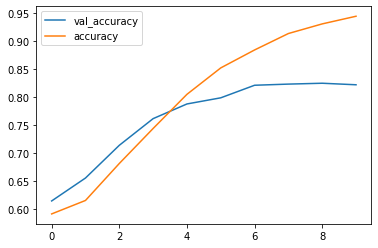

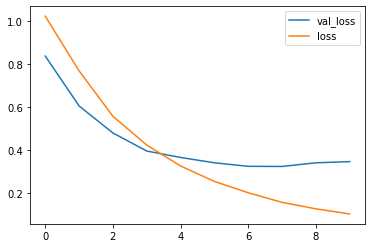

In [41]:
batch_size = 8
epochs = 10

model_bilstm.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

history_bilstm = model_bilstm.fit(train_sentences, train_tags_1hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(dev_sentences, dev_tags_1hot))

df = pd.DataFrame(history_bilstm.history)
df[['val_accuracy', 'accuracy']].plot.line();
df[['val_loss', 'loss']].plot.line();

And again, same sentences were tested.

In [42]:
strange_sentences = ['This track by Ur Favourite Band is awesome, it should win an Ammy'.split(),
                     "Check out this tape, it's is called NLP Tune".split(),
                     "Will you come to The Strokes gig? They will play at Magazzini Generali".split()
                    ]
# convert to integers
strange_sentences_int = [[word2int.get(word, 1) for word in sentence] for sentence in strange_sentences]
# add padding
strange_sentences_int = pad_sequences(strange_sentences_int, maxlen=MAX_LENGTH, padding='post')

predictions = model_bilstm.predict(strange_sentences_int)
print(predictions, predictions.shape)

[[[8.53e-05 2.21e-03 2.34e-06 ... 2.13e-03 2.32e-03 3.55e-01]
  [4.05e-07 1.45e-05 4.50e-08 ... 3.79e-05 5.23e-06 9.90e-01]
  [3.23e-10 1.31e-07 3.34e-10 ... 9.69e-09 4.14e-09 1.00e+00]
  ...
  [3.42e-02 3.45e-02 3.40e-02 ... 3.55e-02 3.68e-02 3.77e-02]
  [3.42e-02 3.45e-02 3.40e-02 ... 3.55e-02 3.68e-02 3.77e-02]
  [3.42e-02 3.45e-02 3.40e-02 ... 3.55e-02 3.68e-02 3.77e-02]]

 [[1.32e-04 6.64e-03 2.80e-05 ... 9.25e-03 2.73e-03 6.41e-01]
  [1.92e-07 3.68e-06 1.09e-07 ... 1.02e-04 1.30e-06 9.96e-01]
  [3.63e-10 6.63e-08 1.08e-09 ... 5.63e-08 1.79e-09 1.00e+00]
  ...
  [3.42e-02 3.45e-02 3.40e-02 ... 3.55e-02 3.68e-02 3.77e-02]
  [3.42e-02 3.45e-02 3.40e-02 ... 3.55e-02 3.68e-02 3.77e-02]
  [3.42e-02 3.45e-02 3.40e-02 ... 3.55e-02 3.68e-02 3.77e-02]]

 [[2.04e-04 4.83e-03 3.62e-05 ... 7.20e-03 4.63e-03 6.54e-01]
  [4.64e-05 1.04e-03 9.01e-06 ... 4.35e-03 6.15e-04 8.67e-01]
  [2.67e-08 1.95e-06 1.76e-08 ... 7.43e-06 2.02e-07 9.99e-01]
  ...
  [3.42e-02 3.45e-02 3.40e-02 ... 3.55e-02 3.68e

In [43]:
print(list(zip(strange_sentences, inverse_transform(strange_sentences, predictions))))

[(['This', 'track', 'by', 'Ur', 'Favourite', 'Band', 'is', 'awesome,', 'it', 'should', 'win', 'an', 'Ammy'], ['O', 'O', 'O', 'B-band', 'I-band', 'I-band', 'O', 'O', 'O', 'O', 'O', 'O', 'O']), (['Check', 'out', 'this', 'tape,', "it's", 'is', 'called', 'NLP', 'Tune'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-misc']), (['Will', 'you', 'come', 'to', 'The', 'Strokes', 'gig?', 'They', 'will', 'play', 'at', 'Magazzini', 'Generali'], ['O', 'O', 'O', 'O', 'O', 'O', 'I-misc', 'O', 'O', 'O', 'O', 'O', 'I-event'])]


I wouldn't say the performance was nor better or worse, the model tended to give less guesses, and those it gave were somewhat more correct than the structured perceptron. Evaluating on the test set, however, the structured perceptron still was confirmed as the better alternative.

In [44]:
loss, accuracy = model_bilstm.evaluate(test_sentences, test_tags_1hot,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

13/13 [==============================] - 2s 6ms/step - loss: 0.3358 - accuracy: 0.8304
Test loss: 0.3358485698699951
Test accuracy: 0.8303914070129395
